In [1]:
# Robot sensor symmetry correction test
# Hans Verdolaga
# MSc Mechatronics 2023
# MC-F23 Thesis

In [2]:
# -----------------------------------------------------------------------------
# Libraries
# -----------------------------------------------------------------------------
# Import user libraries
import hvConfiguration as cfg

# Import system libraries
import time
import os
import numpy as np
import pandas as pd
from scipy.signal import butter,filtfilt
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# -----------------------------------------------------------------------------
# High level information
# -----------------------------------------------------------------------------

In [4]:
# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------
def butterLowPassFilter(data, fs, order = 2):
    nyquist = 0.5 * fs
    normal_cutoff = 1500 / nyquist
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [5]:
# -----------------------------------------------------------------------------
# Data loading
# -----------------------------------------------------------------------------
# Load the data
# symmetryFolder = cfg.sensorSymmetryFolder
# Get symmetry folder with specified date
parentFolder = 'D:\\D drive Documents\\Python 3\\SDU\\SDU - Thesis\\Implementation\\Production 04-05-23\\20230505_data'
symmetryFolder = parentFolder + '\\symmetry_sensor_data\\'

# Initialize global dataframe
df = pd.DataFrame()

# Loop through all files saved in the symmetry folder
for file in os.listdir(symmetryFolder):
    # Read csv
    dfFile = pd.read_csv(symmetryFolder + file)

    # Append to global dataframe
    df = pd.concat([df, dfFile], ignore_index=True)

In [6]:
# Create a difference column to investigate distribution
df["diff"] = df["sensor0"] - df["sensor1"]

# Sort by sensor 2
df = df.sort_values(by=["sensor2"])

# Create running average column for difference column
df["diffAvg"] = df["diff"].rolling(window=50).mean()

# Cut off rows for sensor 2 values above 10000
df = df[df["sensor2"] < 20000]

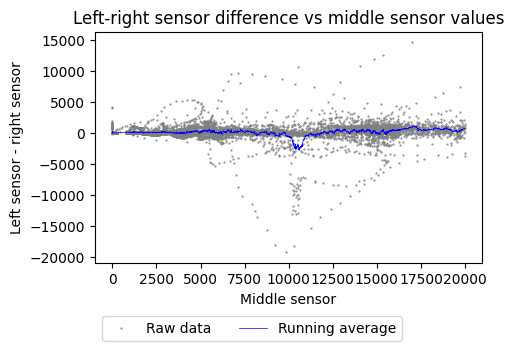

In [23]:
# Plot diff against sensor 2 data
plt.figure(figsize=(5, 3))

plt.plot(df["sensor2"], df["diff"], '.', color='gray', markersize=1)
plt.plot(df["sensor2"], df["diffAvg"], 'b', linewidth=0.5)
plt.legend(["Raw data", "Running average"], loc='upper left', bbox_to_anchor=(0, -0.2), ncol=2)
plt.xlabel("Middle sensor")
plt.ylabel("Left sensor - right sensor")
plt.title("Left-right sensor difference vs middle sensor values")
plt.show()

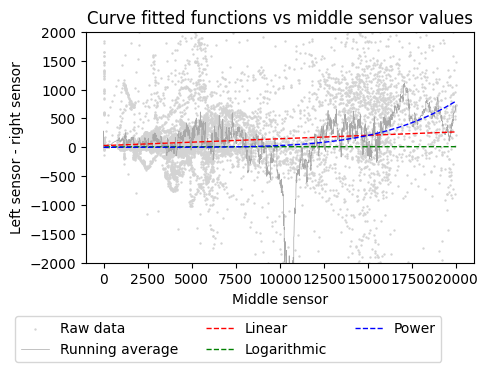

In [30]:
# Fit a straight line curve to the difference column
# Get the coefficients
def func0(x, a, b):
    return a*x + b
coeffsA = curve_fit(func0, df["sensor2"], df["diff"], maxfev=10000)[0]

# Fit a logarithmic curve to the difference column
def func1(x, a, b):
    return a*np.log(x) + b
coeffsB = curve_fit(func1, df["sensor2"], df["diff"], maxfev=10000)[0]

# Fit a power curve to the difference column
def func2(x, a, b):
    return a*np.power(x, b)
coeffsC = curve_fit(func2, df["sensor2"], df["diff"], maxfev=10000)[0]

# Plot the line
# Scatter with small marker size
plt.figure(figsize=(5, 3))
plt.scatter(df["sensor2"], df["diff"], s=0.5, color="lightgrey")
plt.plot(df["sensor2"], df["diffAvg"], color="darkgrey", linewidth=0.5)
plt.plot(df["sensor2"], func0(df["sensor2"], coeffsA[0], coeffsA[1]), color="red", linestyle="dashed", linewidth=1)
plt.plot(df["sensor2"], func1(df["sensor2"], coeffsB[0], coeffsB[1]), color="green", linestyle="dashed", linewidth=1)
plt.plot(df["sensor2"], func2(df["sensor2"], coeffsC[0], coeffsC[1]), color="blue", linestyle="dashed", linewidth=1)
plt.legend(["Raw data","Running average", "Linear", "Logarithmic", "Power"], loc='upper left', bbox_to_anchor=(-0.2, -0.2), ncol=3)

plt.xlabel("Middle sensor")
plt.ylabel("Left sensor - right sensor")
plt.title("Curve fitted functions vs middle sensor values")
# Set y axis limits
plt.ylim(-2000, 2000)
plt.show()


In [62]:
coeffs[0]*3000 + coeffs[1]

252.98312329430854

In [63]:
# Add column for corrected sensor 0
df["sensor0Corrected"] = df["sensor0"] - (coeffs[0]*df["sensor2"] + coeffs[1])/2
# Add column for corrected sensor 1
df["sensor1Corrected"] = df["sensor1"] + (coeffs[0]*df["sensor2"] + coeffs[1])/2

Text(0.5, 1.0, 'Corrected Sensor 0 vs Sensor 2 readings')

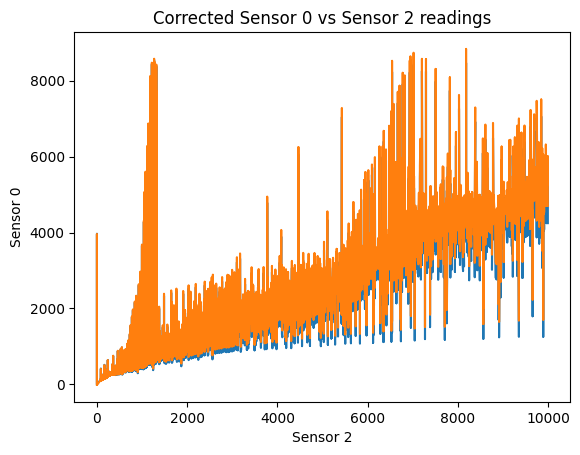

In [65]:
# Plot corrected sensor 0 against sensor 2
plt.plot(df["sensor2"], df["sensor1"])
plt.plot(df["sensor2"], df["sensor1Corrected"])
plt.xlabel("Sensor 2")
plt.ylabel("Sensor 0")
plt.title("Corrected Sensor 0 vs Sensor 2 readings")